### Calculate proteome coverage per strain

In [1]:
import pandas as pd
from Bio import SeqIO
import glob
from pathlib import Path
import matplotlib.pyplot as plt

from Bio import Phylo

In [2]:
# helper functions

def extract_protein(record):
    if ">ST" in record.id:
        # e.g. >ST73_ECFI4_00021
        protein_id = "_".join(record.id.split('_')[1:3]).split('...')[0]
    elif "|" in record.id:
        # e.g. sp|A1A7A0|RSMA_ECOK1_00001
        # or >K12_sp|P0CE51|INSH3_ECOLI
        protein_id = record.id.split("|")[1]
    else:
        # e.g. UPI00001363DE
        protein_id = record.id #line.split('_')[1]
    return protein_id

def read_fasta(proteome_path):
    proteins = []
    for record in SeqIO.parse(proteome_path, "fasta"):
        proteins.append(extract_protein(record))
    return proteins

def update_relationship_phrase(row, biosequence_to_relationship_phrase):
    if row["relationship_phrase"] == "identical":
        # return the relationship phrase of the protein it is identical to (=> the reference biosequence)
        identical_to = row["reference_biosequence"]
        return biosequence_to_relationship_phrase[identical_to]
    return row["relationship_phrase"]

# read in all protein IDs, simplify tiers as described in the paper

def parse_IDs(files):
    """
    Parse protein IDs from files and return a dictionary with tier names as keys and DataFrames as values.
    """
    IDs = {}

    for file in files:
        name = file.name
        name = name.replace(".tsv", "").replace("PA2_", "")
        IDs[name] = pd.read_table(file)
        # filter out phages
        IDs[name] = IDs[name][~IDs[name]["biosequence_name"].str.contains("PHAGE_sp")]

        # update relationship phrase for proteins that are identical to an indistinguishable protein, not an identical one
        biosequence_to_relationship_phrase = {row["biosequence_name"]: row["relationship_phrase"] for index, row in IDs[name].iterrows()}
        IDs[name]["relationship_phrase"] = IDs[name].apply(lambda row: update_relationship_phrase(row, biosequence_to_relationship_phrase), axis=1)

    # combine uncertain tiers into one
    IDs["uncertain"] = pd.concat([IDs["weak"], IDs["insufficient_evidence"], IDs["subsumed"], IDs["indistinguishable_representative"]])
    del IDs["insufficient_evidence"]
    del IDs["subsumed"]
    del IDs["indistinguishable_representative"]

    # combine canonical and noncore canonical
    IDs["canonical"] = pd.concat([IDs["canonical"], IDs["noncore_canonical"]])

    # remove indistinguishables from canonical and add them to own tier
    IDs["indistinguishable_from_canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] == "indistinguishable"]
    IDs["canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] != "indistinguishable"]

    # remove indistinguishables from uncertain and add them to uncertain tier
    IDs["uncertain"] = pd.concat([IDs["uncertain"], IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] == "indistinguishable"]])
    IDs["marginally_distinguished"] = IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] != "indistinguishable"]

    del IDs["all_tiers"]
    del IDs["noncore_canonical"]

    print("Parsed the following protein IDs per tier:")

    for key in IDs:
        IDs[key] = IDs[key].drop_duplicates(subset=["biosequence_name"])
        print(f'{key}: {len(IDs[key])}')

    return IDs


def count_proteome_coverage(proteomes, IDs):
    """
    Count the number of proteins in each tier for each strain proteome.
    """

    # count proteins in each tier for each strain
    counts = []

    for proteome in proteomes:
        proteins = read_fasta(proteome)
        strain = proteome.split('/')[-1].split('.')[0].split("_")[-1]
        tiers = list(IDs.keys()) + ["reference"]
        for tier in tiers:
            if tier == "reference":
                identified_proteins = proteins
            else:
                identified_proteins = IDs[tier][IDs[tier]["biosequence_name"].isin(proteins)]
            counts.append([strain, tier, len(identified_proteins)])

    df = pd.DataFrame(counts, columns=["strain", "tier", "count"])
    pivot_df = df.pivot(index="strain", columns="tier", values="count").reset_index().set_index("strain")
    pivot_df["observed"] = pivot_df["canonical"] + pivot_df["marginally_distinguished"] + pivot_df["uncertain"] + pivot_df["indistinguishable_from_canonical"]
    pivot_df["not_observed"] = pivot_df["reference"] - pivot_df["observed"]
    pivot_df = pivot_df[['observed', 'not_observed', 'canonical', 'indistinguishable_from_canonical', 'marginally_distinguished', 'uncertain', 'reference']]

    # Calculate percentages
    for tier in pivot_df.columns:
        pivot_df[tier] = (pivot_df[tier] / pivot_df["reference"]) * 100

    pivot_df = pivot_df.drop(columns=["reference", "observed"]).sort_values(by="not_observed", ascending=True)


    pivot_df["observed_total"] = pivot_df["canonical"] + pivot_df["indistinguishable_from_canonical"] + pivot_df["marginally_distinguished"] + pivot_df["uncertain"]
    pivot_df = pivot_df.sort_values(by="observed_total", ascending=False)
    pivot_df.drop(columns=["observed_total"], inplace=True)

    return pivot_df



def plot_strain_coverage(counts, phage_tree, ecoli_tree):
    """ Plot the strain proteome coverage as a stacked bar chart.
    """

    # add fake entry to get gap between e coli and phage
    counts.loc["fake"] = [0, 0, 0, 0, 0]

    order = [term.name for term in ecoli_tree.get_terminals()][::-1] + ["fake"] + [term.name for term in phage_tree.get_terminals()]

    # sort rows
    strain_coverage_ecoli = counts.loc[order]

    # sort cols
    strain_coverage_ecoli = strain_coverage_ecoli[["canonical", "indistinguishable_from_canonical", "marginally_distinguished", "uncertain"]]
    strain_coverage_ecoli = strain_coverage_ecoli.rename(columns={"marginally_distinguished": "marginally distinguished", "indistinguishable_from_canonical": "indistinguishable from canonical"})


    ax = strain_coverage_ecoli.plot(kind='bar', stacked=True, figsize=(10, 5), title="", fontsize=15, color = ["#2CA02C","#974EA4", "#FF7E00","#1F77B4"])

    # sort legend the same way as bars
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: strain_coverage_ecoli.columns.tolist().index(x[1]))
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)

    # add y label
    plt.ylabel("% of total proteome", fontsize=25)
    plt.xlabel("Strain", fontsize=20)

    # Move the legend to the upper right corner outside the plot
    plt.legend(sorted_handles[::-1], sorted_labels[::-1], title="Evidence level", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)

    # remove the x tick label from fake bar
    ax.set_xticklabels([term.name for term in ecoli_tree.get_terminals()][::-1] + [""] + [term.name for term in phage_tree.get_terminals()])

    # rename K12 to E. coli K-12 in x tick labels
    ax.set_xticklabels([term.name.replace("K12", "MG1655").replace("APEC", "APEC O1:K1") for term in ecoli_tree.get_terminals()][::-1] + [""] + [term.name for term in phage_tree.get_terminals()])

    # remove the x tick from the fake bar
    xticks = ax.xaxis.get_major_ticks()
    xticks[16].set_visible(False)

    # make y axis ticks bigger
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=20)

    # make legend title bigger
    plt.setp(ax.get_legend().get_title(), fontsize='20')

    # change figure size
    plt.gcf().set_size_inches(10, 5)

In [3]:
protein_id_folder = "../data/Fig1_Strain_proteome_coverage/per_evidence_level"
files = Path(protein_id_folder).glob("*.tsv")

crap_fasta = "../data/Fig1_Strain_proteome_coverage/reference_proteomes/contaminants/PeptideAtlas_contaminants_woEcoli.fasta"
reference_proteome = "../data/Fig1_Strain_proteome_coverage/strain_proteomes/uniprot_UP000000625_08_2_24_K12.fasta"

folder_path_strains = '../data/Fig1_Strain_proteome_coverage/reference_proteomes/strain_proteomes/*.fasta'
strain_proteomes = glob.glob(folder_path_strains)

folder_phage_proteomes = "../data/Fig1_Strain_proteome_coverage/reference_proteomes/phage_proteomes/*.fasta"
phage_proteomes = glob.glob(folder_phage_proteomes)

proteomes = strain_proteomes + phage_proteomes

# parse newick tree for ordering of strains
ecoli_tree = Phylo.read("../data/Fig1_Strain_proteome_coverage/newick_trees/ecoli.nwk", "newick")
phage_tree = Phylo.read("../data/Fig1_Strain_proteome_coverage/newick_trees/phages.nwk", "newick")


Parsed the following protein IDs per tier:
canonical: 17815
marginally_distinguished: 4172
weak: 1832
uncertain: 16307
indistinguishable_from_canonical: 3765


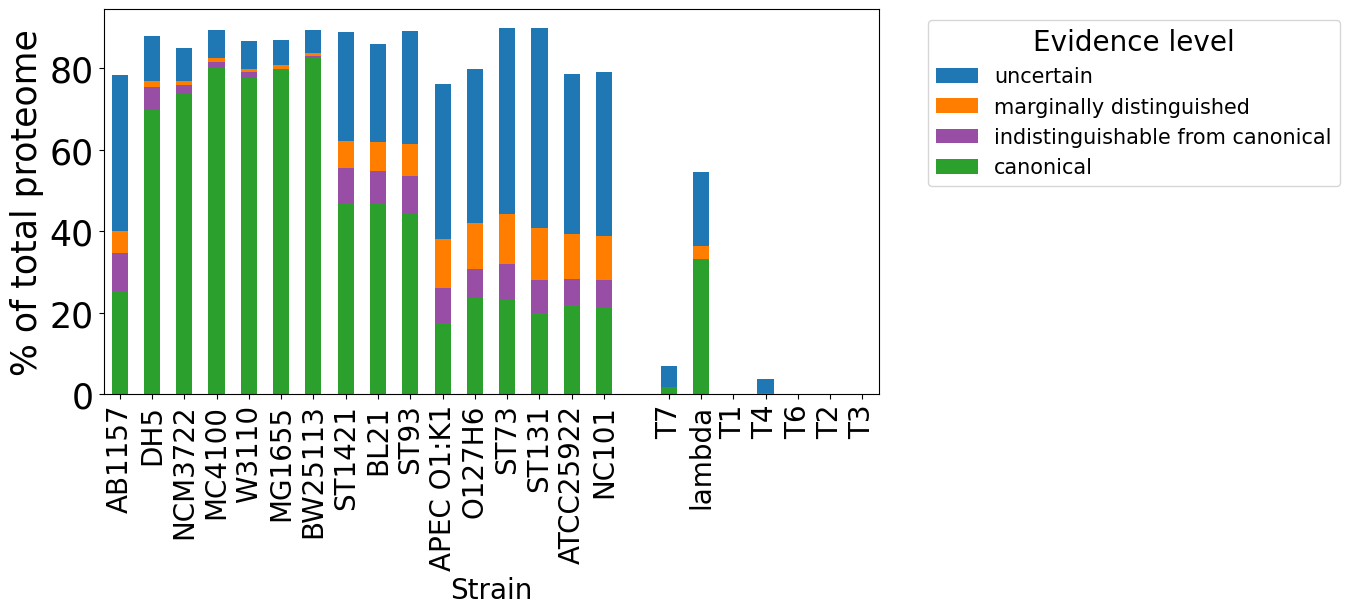

In [4]:
# read in protein IDs from PeptideAtlas tables
IDs = parse_IDs(files)

# calculate coverage of each strain proteome
counts = count_proteome_coverage(proteomes, IDs)

plot_strain_coverage(counts, phage_tree, ecoli_tree)